# Lecture 6. Neural Networks

**How to train your neurons**

Joaquin Vanschoren

In [1]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots 
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.4
    plt.rcParams.update(print_config)

## Overview
* Neural architectures
* Training neural nets
    * Forward pass: Tensor operations
    * Backward pass: Backpropagation
* Neural network design:
    * Activation functions
    * Weight initialization
    * Optimizers
* Neural networks in practice
* Model selection
    * Early stopping
    * Memorization capacity and information bottleneck
    * L1/L2 regularization
    * Dropout
    * Batch normalization


In [2]:
def draw_neural_net(ax, layer_sizes, draw_bias=False, labels=False, activation=False, sigmoid=False,
                    weight_count=False, random_weights=False, show_activations=False, figsize=(4, 4)):
    """
    Draws a dense neural net for educational purposes
    Parameters:
        ax: plot axis
        layer_sizes: array with the sizes of every layer
        draw_bias: whether to draw bias nodes
        labels: whether to draw labels for the weights and nodes
        activation: whether to show the activation function inside the nodes
        sigmoid: whether the last activation function is a sigmoid
        weight_count: whether to show the number of weights and biases
        random_weights: whether to show random weights as colored lines
        show_activations: whether to show a variable for the node activations
        scale_ratio: ratio of the plot dimensions, e.g. 3/4
    """
    figsize = (figsize[0]*fig_scale, figsize[1]*fig_scale)
    left, right, bottom, top = 0.1, 0.89*figsize[0]/figsize[1], 0.1, 0.89
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    colors = ['greenyellow','cornflowerblue','lightcoral']
    w_count, b_count = 0, 0
    ax.set_xlim(0, figsize[0]/figsize[1])
    ax.axis('off')
    ax.set_aspect('equal')
    txtargs = {"fontsize":12*fig_scale, "verticalalignment":'center', "horizontalalignment":'center', "zorder":5}
    
    # Draw biases by adding a node to every layer except the last one
    if draw_bias:
        layer_sizes = [x+1 for x in layer_sizes]
        layer_sizes[-1] = layer_sizes[-1] - 1
        
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2. 
        node_size = v_spacing/len(layer_sizes) if activation and n!=0 else v_spacing/3.
        if n==0:
            color = colors[0]
        elif n==len(layer_sizes)-1:
            color = colors[2]
        else:
            color = colors[1]
        for m in range(layer_size):
            ax.add_artist(plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), radius=node_size,
                                      color=color, ec='k', zorder=4, linewidth=fig_scale))
            b_count += 1
            nx, ny = n*h_spacing + left, layer_top - m*v_spacing
            nsx, nsy = [n*h_spacing + left,n*h_spacing + left], [layer_top - m*v_spacing - 0.5*node_size*2,layer_top - m*v_spacing + 0.5*node_size*2]
            if draw_bias and m==0 and n<len(layer_sizes)-1:
                ax.text(nx, ny, r'$1$', **txtargs)
            elif labels and n==0:
                ax.text(n*h_spacing + left,layer_top + v_spacing/1.5, 'input', **txtargs)
                ax.text(nx, ny, r'$x_{}$'.format(m), **txtargs)
            elif labels and n==len(layer_sizes)-1:
                if activation:
                    if sigmoid:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z \;\;\; \sigma$", **txtargs)
                    else:
                        ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; g$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:        
                        ax.text(n*h_spacing + left + 1.5*node_size,layer_top - m*v_spacing, r"$\hat{y}$", fontsize=12*fig_scale, 
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='r')

                else:
                    ax.text(nx, ny, r'$o_{}$'.format(m), **txtargs)
                ax.text(n*h_spacing + left,layer_top + v_spacing, 'output', **txtargs)
            elif labels:
                if activation:
                    ax.text(n*h_spacing + left,layer_top - m*v_spacing, r"$z_{} \;\; f$".format(m), **txtargs)
                    ax.add_artist(plt.Line2D(nsx, nsy, c='k', zorder=6))
                    if show_activations:        
                        ax.text(n*h_spacing + left + node_size*1.2 ,layer_top - m*v_spacing, r"$a_{}$".format(m), fontsize=12*fig_scale, 
                                verticalalignment='center', horizontalalignment='left', zorder=5, c='b')
                else:
                    ax.text(nx, ny, r'$h_{}$'.format(m), **txtargs)
                
            
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                if not (draw_bias and o==0 and len(layer_sizes)>2 and n<layer_size_b-1):
                    xs = [n*h_spacing + left, (n + 1)*h_spacing + left]
                    ys = [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing]
                    color = 'k' if not random_weights else plt.cm.bwr(np.random.random())
                    ax.add_artist(plt.Line2D(xs, ys, c=color, alpha=0.6))
                    if not (draw_bias and m==0):
                        w_count += 1
                    if labels and not random_weights:
                        wl = r'$w_{{{},{}}}$'.format(m,o) if layer_size_b>1 else r'$w_{}$'.format(m)
                        ax.text(xs[0]+np.diff(xs)/2, np.mean(ys)-np.diff(ys)/9, wl, ha='center', va='center', 
                                 fontsize=12*fig_scale)
    # Count
    if weight_count:
        b_count = b_count - layer_sizes[0]
        if draw_bias:
            b_count = b_count - (len(layer_sizes) - 2)
        ax.text(right*1.05, bottom, "{} weights, {} biases".format(w_count, b_count), ha='center', va='center')


## Architecture
* Logistic regression, drawn in a different, neuro-inspired, way
    * Linear model: inner product ($z$) of input vector $\mathbf{x}$ and weight vector $\mathbf{w}$, plus bias $w_0$
    * Logistic (or sigmoid) function maps the output to a probability in [0,1]
    * Uses log loss (cross-entropy) and gradient descent to learn the weights
        
$$\hat{y}(\mathbf{x}) = \text{sigmoid}(z) = \text{sigmoid}(w_0 + \mathbf{w}\mathbf{x}) = \text{sigmoid}(w_0 + w_1 * x_1 + w_2 * x_2 +... + w_p * x_p)$$

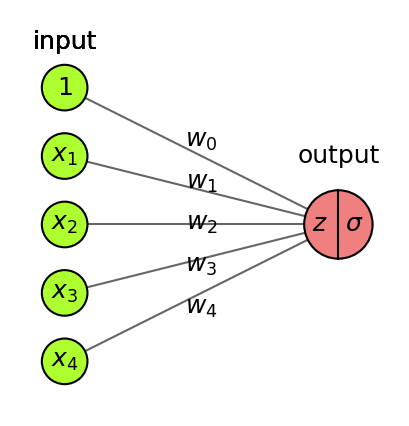

In [3]:
fig = plt.figure(figsize=(3*fig_scale,3*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [4, 1], activation=True, draw_bias=True, labels=True, sigmoid=True)

### Basic Architecture
* Add one (or more) _hidden_ layers $h$ with $k$ nodes (or units, cells, neurons)
    * Every 'neuron' is a tiny function, the network is an arbitrarily complex function
    * Weights $w_{i,j}$ between node $i$ and node $j$ form a weight matrix $\mathbf{W}^{(l)}$ per layer $l$
* Every neuron weights the inputs $\mathbf{x}$ and passes it through a non-linear activation function
    * Activation functions ($f,g$) can be different per layer, output $\mathbf{a}$ is called activation
$$\color{blue}{h(\mathbf{x})} = \color{blue}{\mathbf{a}} = f(\mathbf{z}) = f(\mathbf{W}^{(1)} \color{green}{\mathbf{x}}+\mathbf{w}^{(1)}_0) \quad \quad \color{red}{o(\mathbf{x})} = g(\mathbf{W}^{(2)}  \color{blue}{\mathbf{a}}+\mathbf{w}^{(2)}_0)$$

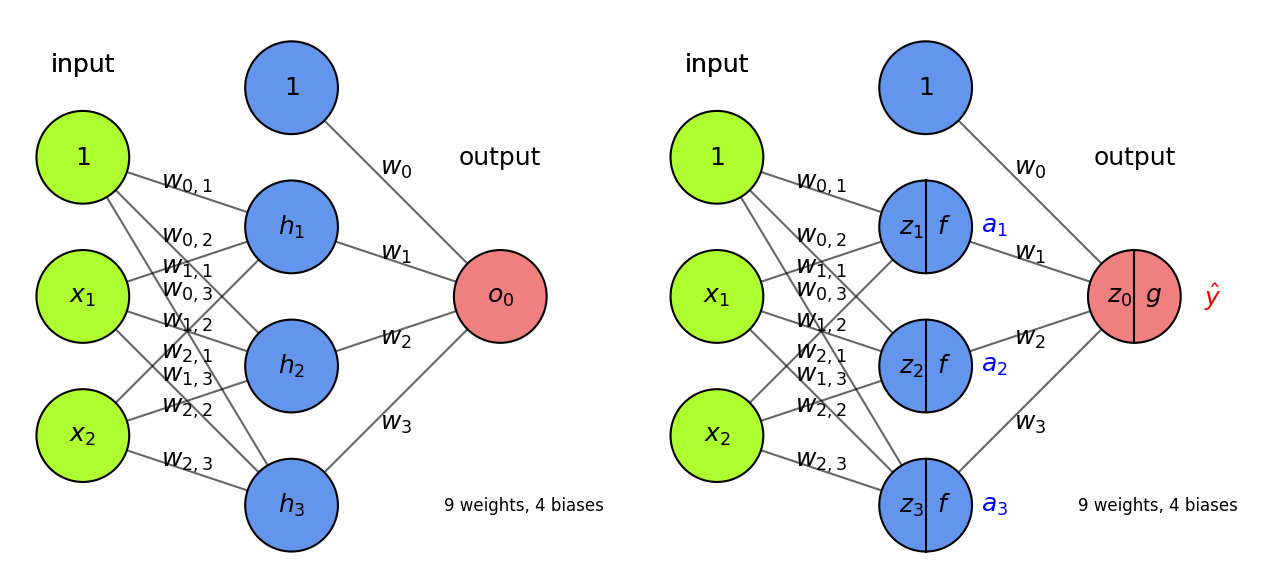

In [4]:
fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,5*fig_scale))
draw_neural_net(axes[0], [2, 3, 1],  draw_bias=True, labels=True, weight_count=True, figsize=(4, 4))
draw_neural_net(axes[1], [2, 3, 1],  activation=True, show_activations=True, draw_bias=True, 
                labels=True, weight_count=True,  figsize=(4, 4))

### More layers
* Add more layers, and more nodes per layer, to make the model more complex
    * For simplicity, we don't draw the biases (but remember that they are there)
* In _dense_ (fully-connected) layers, every previous layer node is connected to all nodes
* The output layer can also have multiple nodes (e.g. 1 per class in multi-class classification)

In [5]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_dense_net(nr_layers=(0,6,1), nr_nodes=(1,12,1)):
    fig = plt.figure(figsize=(10*fig_scale, 5*fig_scale))
    ax = fig.gca()
    ax.axis('off')
    hidden = [nr_nodes]*nr_layers
    draw_neural_net(ax, [5] + hidden + [5], weight_count=True, figsize=(6, 4))
    plt.show()

interactive(children=(IntSlider(value=3, description='nr_layers', max=6), IntSlider(value=6, description='nr_n…

In [6]:
if not interactive:
    plot_dense_net(nr_layers=6, nr_nodes=10)

### Why layers?
* Each layer acts as a _filter_ and learns a new _representation_ of the data
    * Subsequent layers can learn iterative refinements
    * Easier than learning a complex relationship in one go
* Example: for image input, each layer yields new (filtered) images
    * Can learn multiple mappings at once: weight _tensor_ $\mathit{W}$ yields activation tensor $\mathit{A}$
    * From low-level patterns (edges, end-points, ...) to combinations thereof
    * Each neuron 'lights up' if certain patterns occur in the input

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/00_layers2.png" alt="ml" style="width: 50%"/>

### Other architectures
* There exist MANY types of networks for many different tasks
* Convolutional nets for image data, Recurrent nets for sequential data,...
* Also used to learn representations (embeddings), generate new images, text,...

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/neural_zoo.png" alt="ml" style="width: 1200px;"/>

## Training Neural Nets
* Design the architecture, choose activation functions (e.g. sigmoids)
* Choose a way to initialize the weights (e.g. random initialization)
* Choose a _loss function_ (e.g. log loss) to measure how well the model fits training data
* Choose an _optimizer_ (typically an SGD variant) to update the weights

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_overview.png" alt="ml" style="width: 45%"/>

### Mini-batch Stochastic Gradient Descent (recap)
1. Draw a batch of *batch_size* training data $\mathbf{X}$ and $\mathbf{y}$
2. _Forward pass_ : pass $\mathbf{X}$ though the network to yield predictions $\mathbf{\hat{y}}$
3. Compute the loss $\mathcal{L}$ (mismatch between  $\mathbf{\hat{y}}$ and $\mathbf{y}$)
4. _Backward pass_ : Compute the gradient of the loss with regard to every weight
    * _Backpropagate_ the gradients through all the layers
5. Update $W$: $W_{(i+1)} = W_{(i)} - \frac{\partial L(x, W_{(i)})}{\partial W} * \eta$

Repeat until n passes (epochs) are made through the entire training set

In [7]:
# TODO: show the actual weight updates
@interact
def draw_updates(iteration=(1,100,1)):
    fig, ax = plt.subplots(1, 1, figsize=(6*fig_scale, 4*fig_scale))
    np.random.seed(iteration)
    draw_neural_net(ax, [6,5,5,3], labels=True, random_weights=True, show_activations=True, figsize=(6, 4));
    plt.show()

interactive(children=(IntSlider(value=50, description='iteration', min=1), Output()), _dom_classes=('widget-in…

In [8]:
if not interactive:
    draw_updates(iteration=1)

### Forward pass
* We can naturally represent the data as _tensors_
    * Numerical n-dimensional array (with n axes)
    * 2D tensor: matrix (samples, features)
    * 3D tensor: time series (samples, timesteps, features)
    * 4D tensor: color images (samples, height, width, channels)
    * 5D tensor: video (samples, frames, height, width, channels)  
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_timeseries.png" alt="ml" style="float: left; width: 30%;"/>
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_images.png" alt="ml" style="float: left; width: 30%;"/>

#### Tensor operations
* The operations that the network performs on the data can be reduced to a _series of tensor operations_
    * These are also much easier to run on GPUs
* A dense layer with sigmoid activation, input tensor $\mathbf{X}$, weight tensor $\mathbf{W}$, bias $\mathbf{b}$:

``` python
y = sigmoid(np.dot(X, W) + b)
```
* Tensor dot product for 2D inputs ($a$ samples, $b$ features, $c$ hidden nodes)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/08_dot.png" alt="ml" style="width: 40%"/>

#### Element-wise operations

* Activation functions and addition are element-wise operations:

``` python
def sigmoid(x):
  return 1/(1 + np.exp(-x)) 

def add(x, y):
  return x + y
```

* Note: if y has a lower dimension than x, it will be _broadcasted_: axes are added to match the dimensionality, and y is repeated along the new axes 

``` python
>>> np.array([[1,2],[3,4]]) + np.array([10,20])
array([[11, 22],
       [13, 24]])
```

### Backward pass (backpropagation)
* For last layer, compute gradient of the loss function $\mathcal{L}$ w.r.t all weights of layer $l$

$$\nabla \mathcal{L} = \frac{\partial \mathcal{L}}{\partial W^{(l)}} = 
                  \begin{bmatrix}
                    \frac{\partial \mathcal{L}}{\partial w_{0,0}} & \ldots & \frac{\partial \mathcal{L}}{\partial w_{0,l}} \\
                    \vdots & \ddots & \vdots \\
                    \frac{\partial \mathcal{L}}{\partial w_{k,0}}  & \ldots & \frac{\partial \mathcal{L}}{\partial w_{k,l}}
                  \end{bmatrix}$$
                  
* Sum up the gradients for all $\mathbf{x}_j$ in minibatch: $\sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W^{(l)}}$
* Update all weights in a layer at once (with learning rate $\eta$): $W_{(i+1)}^{(l)} = W_{(i)}^{(l)} - \eta \sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W_{(i)}^{(l)}}$ 
* Repeat for next layer, iterating backwards (most efficient, avoids redundant calculations)
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/01_gradient_descent.jpg" alt="ml" style="width: 40%"/>

#### Example
* Imagine feeding a single data point, output is $\hat{y} = g(z) = g(w_0 + w_1 * a_1 + w_2 * a_2 +... + w_p * a_p)$
* Decrease loss by updating weights:
    * Update the weights of last layer to maximize improvement: 
   $w_{i,(new)} = w_{i} - \frac{\partial \mathcal{L}}{\partial w_i} * \eta$
    * To compute gradient $\frac{\partial \mathcal{L}}{\partial w_i}$ we need the chain rule: $f(g(x)) = f'(g(x)) * g'(x)$
$$\frac{\partial \mathcal{L}}{\partial w_i} = \color{red}{\frac{\partial \mathcal{L}}{\partial g}} \color{blue}{\frac{\partial \mathcal{g}}{\partial z_0}} \color{green}{\frac{\partial \mathcal{z_0}}{\partial w_i}}$$
* E.g., with $\mathcal{L} = \frac{1}{2}(y-\hat{y})^2$ and sigmoid $\sigma$: $\frac{\partial \mathcal{L}}{\partial w_i} = \color{red}{(y - \hat{y})} * \color{blue}{\sigma'(z_0)} * \color{green}{a_i}$

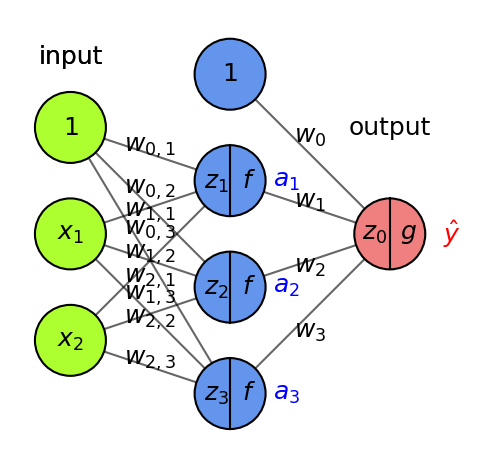

In [9]:
fig = plt.figure(figsize=(4*fig_scale, 3.5*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1],  activation=True, draw_bias=True, labels=True, 
                show_activations=True)

#### Backpropagation (2)
* Another way to decrease the loss $\mathcal{L}$ is to update the activations $a_i$
    * To update $a_i = f(z_i)$, we need to update the weights of the previous layer
    * We want to nudge $a_i$ in the right direction by updating $w_{i,j}$:
$$\frac{\partial \mathcal{L}}{\partial w_{i,j}} = \frac{\partial \mathcal{L}}{\partial a_i} \frac{\partial a_i}{\partial z_i} \frac{\partial \mathcal{z_i}}{\partial w_{i,j}} = \left( \frac{\partial \mathcal{L}}{\partial g} \frac{\partial \mathcal{g}}{\partial z_0} \frac{\partial \mathcal{z_0}}{\partial a_i} \right) \frac{\partial a_i}{\partial z_i} \frac{\partial \mathcal{z_i}}{\partial w_{i,j}}$$
    * We know $\frac{\partial \mathcal{L}}{\partial g}$ and $\frac{\partial \mathcal{g}}{\partial z_0}$ from the previous step, $\frac{\partial \mathcal{z_0}}{\partial a_i} = w_i$, $\frac{\partial a_i}{\partial z_i} = f'$ and $\frac{\partial \mathcal{z_i}}{\partial w_{i,j}} = x_j$

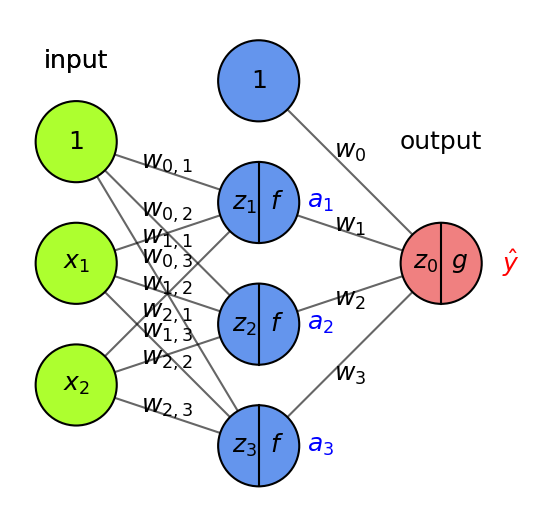

In [10]:
fig = plt.figure(figsize=(4*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1],  activation=True, draw_bias=True, labels=True, 
                show_activations=True)

#### Backpropagation (3)
* With multiple output nodes, $\mathcal{L}$ is the sum of all per-output (per-class) losses
    * $\frac{\partial \mathcal{L}}{\partial a_i}$ is sum of the gradients for every output
* Per layer, sum up gradients for every point $\mathbf{x}$ in the batch: $\sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W}$
* Update all weights of every layer $l$
    * $W_{(i+1)}^{(l)} = W_{(i)}^{(l)} - \eta \sum_{j} \frac{\partial \mathcal{L}(\mathbf{x}_j,y_j)}{\partial W_{(i)}^{(l)}}$ 
* Repeat with a new batch of data until loss converges
* [Nice animation of the entire process](https://youtu.be/Ilg3gGewQ5U?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&t=403)

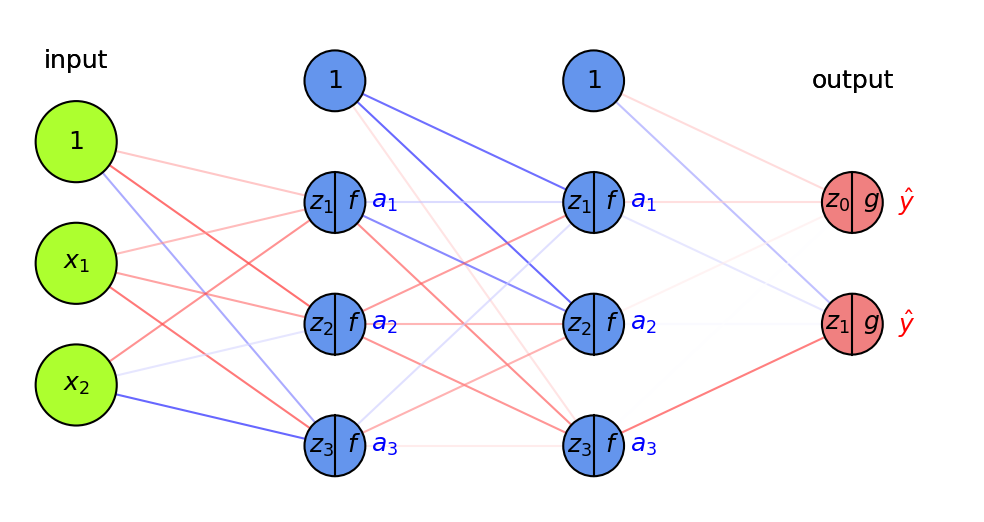

In [11]:
fig = plt.figure(figsize=(8*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 3, 2],  activation=True, draw_bias=True, labels=True, 
                random_weights=True, show_activations=True, figsize=(8, 4))

#### Summary
* The network output $a_o$ is defined by the weights $W^{(o)}$ and biases $\mathbf{b}^{(o)}$ of the output layer, and
* The activations of a hidden layer $h_1$ with activation function $a_{h_1}$, weights $W^{(1)}$ and biases $\mathbf{b^{(1)}}$:

$$\color{red}{a_o(\mathbf{x})} = \color{red}{a_o(\mathbf{z_0})} = \color{red}{a_o(W^{(o)}} \color{blue}{a_{h_1}(z_{h_1})} \color{red}{+ \mathbf{b}^{(o)})} = \color{red}{a_o(W^{(o)}} \color{blue}{a_{h_1}(W^{(1)} \color{green}{\mathbf{x}} + \mathbf{b}^{(1)})}
  \color{red}{+ \mathbf{b}^{(o)})} $$
  
* Minimize the loss by SGD. For layer $l$, compute $\frac{\partial \mathcal{L}(a_o(x))}{\partial W_l}$ and $\frac{\partial \mathcal{L}(a_o(x))}{\partial b_{l,i}}$ using the chain rule
* Decomposes into <span style="color:red">gradient of layer above</span>, <span style="color:blue">gradient of activation function</span>, <span style="color:green">gradient of layer input</span>:

$$\frac{\partial \mathcal{L}(a_o)}{\partial W^{(1)}} = \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_{h_1}}} \color{blue}{\frac{\partial a_{h_1}}{\partial z_{h_1}}} \color{green}{\frac{\partial z_{h_1}}{\partial W^{(1)}}} 
= \left( \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_o}} \color{blue}{\frac{\partial a_o}{\partial z_o}} \color{green}{\frac{\partial z_o}{\partial a_{h_1}}}\right) \color{blue}{\frac{\partial a_{h_1}}{\partial z_{h_1}}} \color{green}{\frac{\partial z_{h_1}}{\partial W^{(1)}}}  $$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/backprop_schema2.png" alt="ml" style="width: 800px;"/>

## Activation functions for hidden layers
* Sigmoid: $f(z) = \frac{1}{1+e^{-z}}$
* Tanh: $f(z) = \frac{2}{1+e^{-2z}} - 1$ 
    * Activations around 0 are better for gradient descent convergence
* Rectified Linear (ReLU): $f(z) = max(0,z)$ 
    * Less smooth, but much faster (note: not differentiable at 0)
* Leaky ReLU: $f(z) = \begin{cases} 0.01z & z<0 \\ z & otherwise \end{cases}$ 

In [12]:
def activation(X, function="sigmoid"):     
    if function == "sigmoid":      
        return 1.0/(1.0 + np.exp(-X))    
    if function == "softmax": 
        return np.exp(X) / np.sum(np.exp(X), axis=0)   
    elif function == "tanh":      
        return np.tanh(X)    
    elif function == "relu":      
        return np.maximum(0,X)    
    elif function == "leaky_relu":      
        return np.maximum(0.1*X,X)
    elif function == "none":      
        return X
    
def activation_derivative(X, function="sigmoid"):   
    if function == "sigmoid": 
        sig = 1.0/(1.0 + np.exp(-X))   
        return sig * (1 - sig)
    elif function == "tanh":      
        return 1 - np.tanh(X)**2   
    elif function == "relu":      
        return np.where(X > 0, 1, 0)
    elif function == "leaky_relu":    
        # Using 0.1 instead of 0.01 to make it visible in the plot
        return np.where(X > 0, 1, 0.1)
    elif function == "none":      
        return X/X
    
def plot_activation(function, ax, derivative=False):
    if function=="softmax":       
        x = np.linspace(-6,6,9)
        ax.plot(x,activation(x, function),lw=2, c='b', linestyle='-', marker='o')
    else:     
        x = np.linspace(-6,6,101)
        ax.plot(x,activation(x, function),lw=2, c='b', linestyle='-') 
        if derivative:
            if function == "relu" or function == "leaky_relu":
                ax.step(x,activation_derivative(x, function),lw=2, c='r', linestyle='-')
            else:
                ax.plot(x,activation_derivative(x, function),lw=2, c='r', linestyle='-')
    ax.set_xlabel("input", fontsize=16*fig_scale)
    ax.set_ylabel(function, fontsize=18*fig_scale)
    ax.tick_params(axis='both', labelsize=16*fig_scale)
    ax.grid()
    
functions = ["sigmoid","tanh","relu","leaky_relu"]

@interact
def plot_activations(function=functions):
    fig, ax = plt.subplots(figsize=(5,1.5))
    plot_activation(function, ax)
    plt.show()

interactive(children=(Dropdown(description='function', options=('sigmoid', 'tanh', 'relu', 'leaky_relu'), valu…

In [13]:
if not interactive:
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    for function, ax in zip(functions,axes):
        plot_activation(function, ax)
    plt.tight_layout();

#### Effect of activation functions on the gradient
* During gradient descent, the gradient depends on the activation function $a_{h}$: $\frac{\partial \mathcal{L}(a_o)}{\partial W^{(l)}} = \color{red}{\frac{\partial \mathcal{L}(a_o)}{\partial a_{h_l}}} \color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}} \color{green}{\frac{\partial z_{h_l}}{\partial W^{(l)}}}$
* If derivative of the activation function $\color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}}$ is 0, the weights $w_i$ are not updated
    * Moreover, the gradients of previous layers will be reduced (vanishing gradient)
* sigmoid, tanh: gradient is very small for large inputs: slow updates
* With ReLU, $\color{blue}{\frac{\partial a_{h_l}}{\partial z_{h_l}}} = 1$ if $z>0$, hence better against vanishing gradients
    * Problem: for very negative inputs, the gradient is 0 and may never recover (dying ReLU)
    * Leaky ReLU has a small (0.01) gradient there to allow recovery

In [14]:
@interact
def plot_activations_derivative(function=functions):
    fig, ax = plt.subplots(figsize=(6,2))
    plot_activation(function, ax, derivative=True)
    plt.legend(['original','derivative'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.25), ncol=2)
    plt.show()

interactive(children=(Dropdown(description='function', options=('sigmoid', 'tanh', 'relu', 'leaky_relu'), valu…

In [15]:
if not interactive:
    fig, axes = plt.subplots(1,4, figsize=(10,2))
    for function, ax in zip(functions,axes):
        plot_activation(function, ax, derivative=True)
    fig.legend(['original','derivative'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.25), ncol=2)
    plt.tight_layout();

#### ReLU vs Tanh
* What is the effect of using non-smooth activation functions?
    * ReLU produces piecewise-linear boundaries, but allows deeper networks
    * Tanh produces smoother decision boundaries, but is slower

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from mglearn.plot_2d_separator import plot_2d_classification
import time

@interact
def plot_boundary(nr_layers=(1,4,1)):
    X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        random_state=42)
    
    # Multi-Layer Perceptron with ReLU
    mlp = MLPClassifier(solver='lbfgs', random_state=0,
                        hidden_layer_sizes=[10]*nr_layers)
    start = time.time()
    mlp.fit(X_train, y_train)
    relu_time = time.time() - start
    relu_acc = mlp.score(X_test, y_test)

    # Multi-Layer Perceptron with tanh
    mlp_tanh = MLPClassifier(solver='lbfgs', activation='tanh',
                             random_state=0, hidden_layer_sizes=[10]*nr_layers)
    start = time.time()
    mlp_tanh.fit(X_train, y_train)
    tanh_time = time.time() - start
    tanh_acc = mlp_tanh.score(X_test, y_test)

    fig, axes = plt.subplots(1, 2, figsize=(8*fig_scale, 4*fig_scale))
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[0].set_title("ReLU, acc: {:.2f}, time: {:.2f} sec".format(relu_acc, relu_time))
    plot_2d_classification(mlp, X_train, fill=True, cm='bwr', alpha=.3, ax=axes[0])
    axes[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[1].set_title("tanh, acc: {:.2f}, time: {:.2f} sec".format(tanh_acc, tanh_time))
    plot_2d_classification(mlp_tanh, X_train, fill=True, cm='bwr', alpha=.3, ax=axes[1])
    plt.show()

interactive(children=(IntSlider(value=2, description='nr_layers', max=4, min=1), Output()), _dom_classes=('wid…

In [17]:
if not interactive:
    plot_boundary(nr_layers=2)

#### Activation functions for output layer
* _sigmoid_ converts output to probability in [0,1]
    * For binary classification 
* _softmax_ converts all outputs (aka 'logits') to probabilities that sum up to 1
    * For multi-class classification ($k$ classes)
    * Can cause over-confident models. If so, smooth the labels: $y_{smooth} = (1-\alpha)y + \frac{\alpha}{k}$
$$\text{softmax}(\mathbf{x},i) = \frac{e^{x_i}}{\sum_{j=1}^k e^{x_j}}$$
* For regression, don't use any activation function, let the model learn the exact target

In [18]:
output_functions = ["sigmoid","softmax","none"]

@interact
def plot_output_activation(function=output_functions):
    fig, ax = plt.subplots(figsize=(6,2))
    plot_activation(function, ax)
    plt.show()

interactive(children=(Dropdown(description='function', options=('sigmoid', 'softmax', 'none'), value='sigmoid'…

In [19]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(8,2))
    for function, ax in zip(output_functions[:2],axes):
        plot_activation(function, ax)
    plt.tight_layout();

## Weight initialization
* Initializing weights to 0 is bad: all gradients in layer will be identical (symmetry)
* Too small random weights shrink activations to 0 along the layers (vanishing gradient)
* Too large random weights multiply along layers (exploding gradient, zig-zagging)
* Ideal: small random weights + variance of input and output gradients remains the same
  * Glorot/Xavier initialization (for tanh): randomly sample from  $N(0,\sigma), \sigma = \sqrt{\frac{2}{\text{fan_in + fan_out}}}$
    * fan_in: number of input units, fan_out: number of output units
  * He initialization (for ReLU): randomly sample from  $N(0,\sigma), \sigma = \sqrt{\frac{2}{\text{fan_in}}}$
  * Uniform sampling (instead of $N(0,\sigma)$) for deeper networks (w.r.t. vanishing gradients)



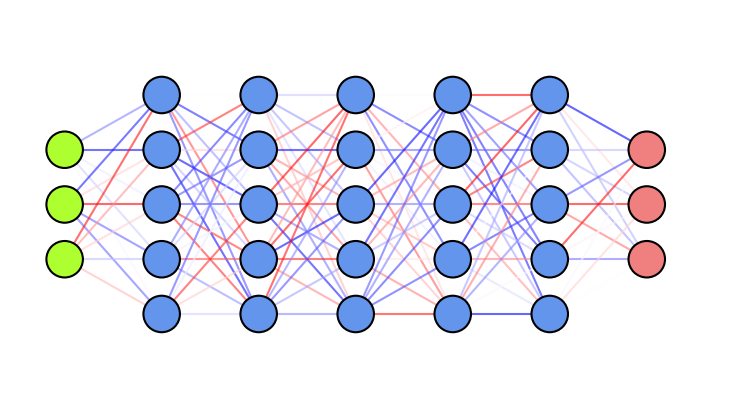

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6*fig_scale, 3*fig_scale))
draw_neural_net(ax, [3, 5, 5, 5, 5, 5, 3], random_weights=True, figsize=(6, 3))

### Weight initialization: transfer learning
* Instead of starting from scratch, start from weights previously learned from similar tasks
    * This is, to a big extent, how humans learn so fast
* Transfer learning: learn weights on task T, transfer them to new network
    * Weights can be frozen, or finetuned to the new data
* Only works if the previous task is 'similar' enough
    * Generally, weights learned on very diverse data (e.g. ImageNet) transfer better
    * Meta-learning: learn a good initialization across many related tasks

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/transfer_learning.png" alt="ml" style="width: 1000px;"/>

In [21]:
import tensorflow as tf
#import tensorflow_addons as tfa

# Toy surface
def f(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# Tensorflow optimizers
class CyclicalLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, maximal_learning_rate, step_size):
        self.initial_learning_rate = initial_learning_rate
        self.maximal_learning_rate = maximal_learning_rate
        self.step_size = step_size

    def __call__(self, step):
        cycle = tf.floor(1 + step / (2 * self.step_size))
        x = tf.abs(step / self.step_size - 2 * cycle + 1)
        return self.initial_learning_rate + (self.maximal_learning_rate - self.initial_learning_rate) * tf.maximum(0.0, (1 - x))

clr_schedule = CyclicalLearningRate(initial_learning_rate=1e-4, 
                                    maximal_learning_rate=0.1, 
                                    step_size=100)
sgd_cyclic = tf.keras.optimizers.SGD(learning_rate=clr_schedule)
sgd = tf.optimizers.SGD(0.01)
lr_schedule = tf.optimizers.schedules.ExponentialDecay(0.02,decay_steps=100,decay_rate=0.96)
sgd_decay = tf.optimizers.SGD(learning_rate=lr_schedule)
momentum = tf.optimizers.SGD(0.005, momentum=0.9, nesterov=False)
nesterov = tf.optimizers.SGD(0.005, momentum=0.9, nesterov=True)
adagrad = tf.optimizers.Adagrad(0.4)
rmsprop = tf.optimizers.RMSprop(learning_rate=0.1)
adam = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

optimizers = [sgd, sgd_decay, momentum, nesterov, adagrad, rmsprop, adam, sgd_cyclic]
opt_names = ['sgd', 'sgd_decay', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'sgd_cyclic']
cmap = plt.cm.get_cmap('tab10')
colors = [cmap(x/10) for x in range(10)]

# Training
all_paths = []
for opt, name in zip(optimizers, opt_names):
    x = tf.Variable(0.8)
    y = tf.Variable(1.6)

    x_history = []
    y_history = []
    loss_prev = 0.0
    max_steps = 100
    for step in range(max_steps):
        with tf.GradientTape() as g:
            loss = f(x, y)
            x_history.append(x.numpy())
            y_history.append(y.numpy())
            grads = g.gradient(loss, [x, y])
            opt.apply_gradients(zip(grads, [x, y]))

    if np.abs(loss_prev - loss.numpy()) < 1e-6:
        break
    loss_prev = loss.numpy()
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
    all_paths.append(path)

In [22]:
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
x_min = 0. - 2
x_max = 0. + 3.5
y_min = 0. - 3.5
y_max = 0. + 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

def plot_optimizers(ax, iterations, optimizers):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    for name, path, color in zip(opt_names, all_paths, colors):
        if name in optimizers:
            p = path[:,:iterations]
            ax.plot([], [], color=color, label=name, lw=3*fig_scale, linestyle='-')
            ax.quiver(p[0,:-1], p[1,:-1], p[0,1:]-p[0,:-1], p[1,1:]-p[1,:-1], scale_units='xy', angles='xy', scale=1, color=color, lw=4)


    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 15*fig_scale}) 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

In [23]:
from decimal import *
from matplotlib.colors import LogNorm

# Training for momentum
all_lr_paths = []
lr_range = [0.005 * i for i in range(0,10)]
for lr in lr_range:
    opt = tf.optimizers.SGD(lr, nesterov=False)

    x_init = 0.8
    x = tf.compat.v1.get_variable('x', dtype=tf.float32, initializer=tf.constant(x_init))
    y_init = 1.6
    y = tf.compat.v1.get_variable('y', dtype=tf.float32, initializer=tf.constant(y_init))

    x_history = []
    y_history = []
    z_prev = 0.0
    max_steps = 100
    for step in range(max_steps):
        with tf.GradientTape() as g:
            z = f(x, y)
            x_history.append(x.numpy())
            y_history.append(y.numpy())
            dz_dx, dz_dy = g.gradient(z, [x, y])
            opt.apply_gradients(zip([dz_dx, dz_dy], [x, y]))

    if np.abs(z_prev - z.numpy()) < 1e-6:
        break
    z_prev = z.numpy()
    x_history = np.array(x_history)
    y_history = np.array(y_history)
    path = np.concatenate((np.expand_dims(x_history, 1), np.expand_dims(y_history, 1)), axis=1).T
    all_lr_paths.append(path)
    
# Plotting
number_of_points = 50
margin = 4.5
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
x_min = 0. - 2
x_max = 0. + 3.5
y_min = 0. - 3.5
y_max = 0. + 2
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

def plot_learning_rate_optimizers(ax, iterations, lr):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    for path, lrate in zip(all_lr_paths, lr_range):
        if round(lrate,3) == lr:
            p = path[:,:iterations]
            ax.plot([], [], color='b', label="Learning rate {}".format(lr), lw=3*fig_scale, linestyle='-')
            ax.quiver(p[0,:-1], p[1,:-1], p[0,1:]-p[0,:-1], p[1,1:]-p[1,:-1], scale_units='xy', angles='xy', scale=1, color='b', lw=4)


    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.legend(loc='lower left', prop={'size': 15*fig_scale}) 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

In [24]:
# Toy plot to illustrate nesterov momentum
# TODO: replace with actual gradient computation?
def plot_nesterov(ax, method="Nesterov momentum"):
    ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 5, 25), norm=LogNorm(), cmap=plt.cm.jet, linewidths=fig_scale, zorder=-1)
    ax.plot(*minima, 'r*', markersize=20*fig_scale)
    
    # toy example
    ax.quiver(-0.8,-1.13,1,1.33, scale_units='xy', angles='xy', scale=1, color='k', alpha=0.5, lw=3, label="previous update")
    # 0.9 * previous update
    ax.quiver(0.2,0.2,0.9,1.2, scale_units='xy', angles='xy', scale=1, color='g', lw=3, label="momentum step")
    if method == "Momentum":
        ax.quiver(0.2,0.2,0.5,0, scale_units='xy', angles='xy', scale=1, color='r', lw=3, label="gradient step")
        ax.quiver(0.2,0.2,0.9*0.9+0.5,1.2, scale_units='xy', angles='xy', scale=1, color='b', lw=3, label="actual step")
    if method == "Nesterov momentum":
        ax.quiver(1.1,1.4,-0.2,-1, scale_units='xy', angles='xy', scale=1, color='r', lw=3, label="'lookahead' gradient step")
        ax.quiver(0.2,0.2,0.7,0.2, scale_units='xy', angles='xy', scale=1, color='b', lw=3, label="actual step")

    ax.set_title(method)
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((-2.5, y_max))
    ax.legend(loc='lower right', prop={'size': 9*fig_scale})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

## Optimizers
### SGD with learning rate schedules
* Using a constant learning $\eta$ rate for weight updates $\mathbf{w}_{(s+1)} = \mathbf{w}_s-\eta\nabla \mathcal{L}(\mathbf{w}_s)$ is not ideal
    * You would need to 'magically' know the right value

In [25]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output

@interact
def plot_lr(iterations=(1,100,1), learning_rate=(0.005,0.04,0.005)):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_learning_rate_optimizers(ax,iterations,round(learning_rate,3))
    plt.show()
    
if not interactive:
    plot_lr(iterations=50, learning_rate=0.02)

interactive(children=(IntSlider(value=50, description='iterations', min=1), FloatSlider(value=0.02, descriptio…

### SGD with learning rate schedules
* Learning rate decay/annealing with decay rate $k$
    * E.g. exponential ($\eta_{s+1} = \eta_{0}  e^{-ks}$), inverse-time ($\eta_{s+1} = \frac{\eta_{0}}{1+ks}$),...
* Cyclical learning rates
    * Change from small to large: hopefully in 'good' region long enough before diverging
    * Warm restarts: aggressive decay + reset to initial learning rate

In [26]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])
    plt.show()

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

In [27]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,4*fig_scale))
    optimizers = ['sgd_decay', 'sgd_cyclic']
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

### Momentum
* Imagine a ball rolling downhill: accumulates momentum, doesn't exactly follow steepest descent
    * Reduces oscillation, follows larger (consistent) gradient of the loss surface
* Adds a velocity vector $\mathbf{v}$ with momentum $\gamma$ (e.g. 0.9, or increase from $\gamma=0.5$ to $\gamma=0.99$)
$$\mathbf{w}_{(s+1)} = \mathbf{w}_{(s)} + \mathbf{v}_{(s)} \qquad \text{with} \qquad
\color{blue}{\mathbf{v}_{(s)}} = \color{green}{\gamma \mathbf{v}_{(s-1)}} - \color{red}{\eta \nabla \mathcal{L}(\mathbf{w}_{(s)})}$$
* Nesterov momentum: Look where momentum step would bring you, compute gradient there 
    * Responds faster (and reduces momentum) when the gradient changes
$$\color{blue}{\mathbf{v}_{(s)}} = \color{green}{\gamma \mathbf{v}_{(s-1)}} - \color{red}{\eta \nabla \mathcal{L}(\mathbf{w}_{(s)} + \gamma \mathbf{v}_{(s-1)})}$$


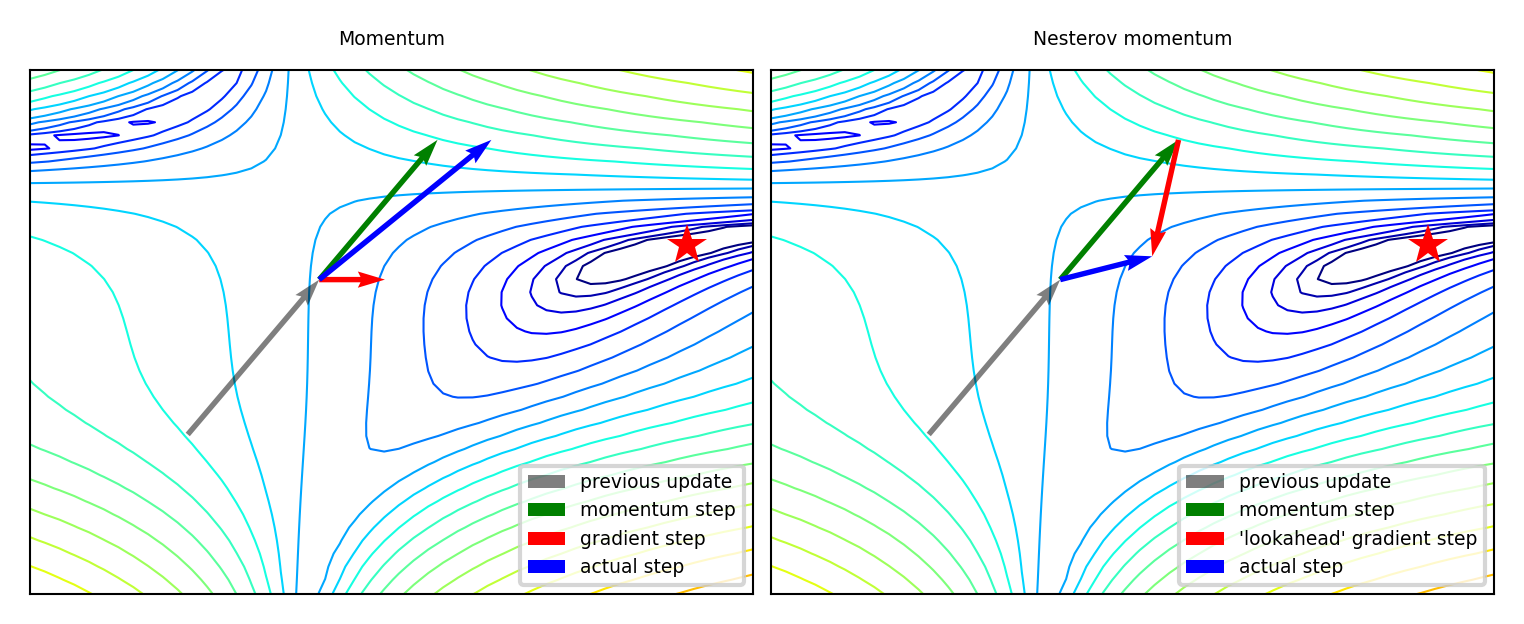

In [28]:
fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,4*fig_scale))
plot_nesterov(axes[0],method="Momentum")
plot_nesterov(axes[1],method="Nesterov momentum")

#### Momentum in practice

In [29]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])
    plt.show()

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

In [30]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,3.5*fig_scale))
    optimizers = [['sgd','momentum'], ['momentum','nesterov']]
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

### Adaptive gradients
* 'Correct' the learning rate for each $w_i$ based on specific local conditions (layer depth, fan-in,...)
* Adagrad: scale $\eta$ according to squared sum of previous gradients $G_{i,(s)} = \sum_{t=1}^s \nabla \mathcal{L}(w_{i,(t)})^2$
    * Update rule for $w_i$. Usually $\epsilon=10^{-7}$ (avoids division by 0), $\eta=0.001$.
$$w_{i,(s+1)} = w_{i,(s)} - \frac{\eta}{\sqrt{G_{i,(s)}+\epsilon}} \nabla \mathcal{L}(w_{i,(s)})$$
* RMSProp: use _moving average_ of squared gradients $m_{i,(s)} = \gamma m_{i,(s-1)} + (1-\gamma) \nabla \mathcal{L}(w_{i,(s)})^2$
    * Avoids that gradients dwindle to 0 as $G_{i,(s)}$ grows. Usually $\gamma=0.9, \eta=0.001$
$$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{\sqrt{m_{i,(s)}+\epsilon}} \nabla \mathcal{L}(w_{i,(s)})$$



In [31]:
if not interactive:
    fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,2.6*fig_scale))
    optimizers = [['sgd','adagrad', 'rmsprop'], ['rmsprop','rmsprop_mom']]
    for function, ax in zip(optimizers,axes):
        plot_optimizers(ax,100,function)
    plt.tight_layout();

In [32]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])
    plt.show()

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

### Adam (Adaptive moment estimation)
* Adam: RMSProp + momentum. Adds moving average for gradients as well ($\gamma_2$ = momentum): 
    * Adds a bias correction to avoid small initial gradients: $\hat{m}_{i,(s)} = \frac{m_{i,(s)}}{1-\gamma}$ and $\hat{g}_{i,(s)} = \frac{g_{i,(s)}}{1-\gamma_2}$
    $$g_{i,(s)} = \gamma_2 g_{i,(s-1)} + (1-\gamma_2) \nabla \mathcal{L}(w_{i,(s)})$$
    $$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{\sqrt{\hat{m}_{i,(s)}+\epsilon}} \hat{g}_{i,(s)}$$

* Adamax: Idem, but use max() instead of moving average: $u_{i,(s)} = max(\gamma u_{i,(s-1)}, |\mathcal{L}(w_{i,(s)})|)$
$$w_{i,(s+1)} = w_{i,(s)}- \frac{\eta}{u_{i,(s)}} \hat{g}_{i,(s)}$$


In [33]:
if not interactive:
    # fig, axes = plt.subplots(1,2, figsize=(10*fig_scale,2.6*fig_scale))
    # optimizers = [['sgd','adam'], ['adam','adamax']]
    # for function, ax in zip(optimizers,axes):
    #     plot_optimizers(ax,100,function)
    # plt.tight_layout();
    
    fig, axes = plt.subplots(1,1, figsize=(5*fig_scale,2.6*fig_scale))
    optimizers = [['sgd','adam']]
    plot_optimizers(axes,100,['sgd','adam'])
    plt.tight_layout();

In [34]:
@interact
def compare_optimizers(iterations=(1,100,1), optimizer1=opt_names, optimizer2=opt_names):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    plot_optimizers(ax,iterations,[optimizer1,optimizer2])
    plt.show()

interactive(children=(IntSlider(value=50, description='iterations', min=1), Dropdown(description='optimizer1',…

### SGD Optimizer Zoo
* RMSProp often works well, but do try alternatives. For even more optimizers, [see here](https://ruder.io/optimizing-gradient-descent).

In [35]:
if not interactive:
    fig, ax = plt.subplots(1,1, figsize=(10*fig_scale,5.5*fig_scale))
    plot_optimizers(ax,100,opt_names)

In [36]:
@interact
def compare_optimizers(iterations=(1,100,1)):
    fig, ax = plt.subplots(figsize=(10*fig_scale,6*fig_scale))
    plot_optimizers(ax,iterations,opt_names)
    plt.show()

interactive(children=(IntSlider(value=50, description='iterations', min=1), Output()), _dom_classes=('widget-i…

In [37]:
from tensorflow.keras import models
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed
import random
import os

#Trying to set all seeds
os.environ['PYTHONHASHSEED']=str(0)
random.seed(0)
seed(0)
set_seed(0)
seed_value= 0

## Neural networks in practice
* There are many practical courses on training neural nets.
    * E.g.: https://pytorch.org/tutorials/, [fast.ai course](https://course.fast.ai/)
* We'll use PyTorch in these examples and the labs.
* Focus on key design decisions, evaluation, and regularization
* Running example: Fashion-MNIST
    * 28x28 pixel images of 10 classes of fashion items

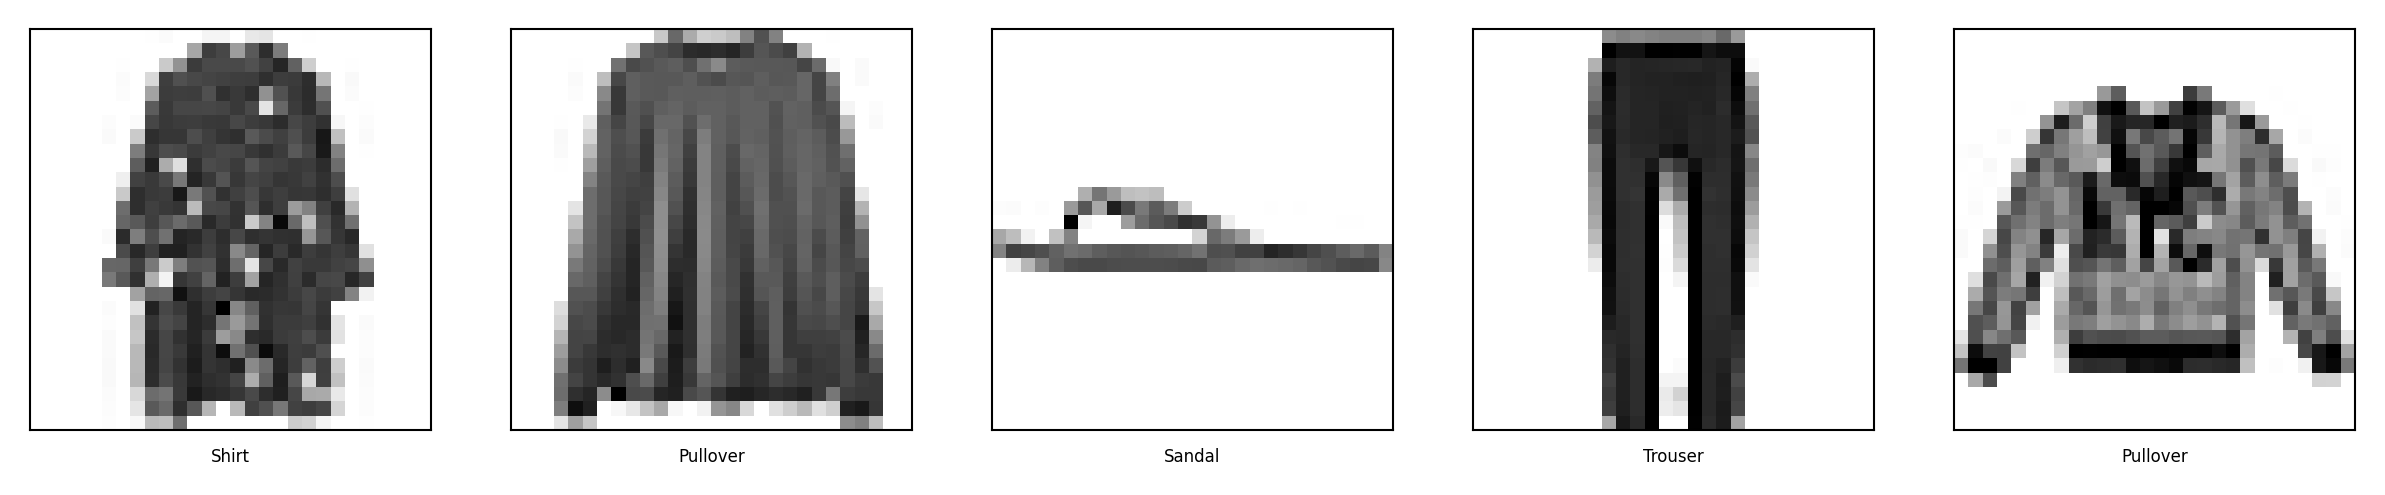

In [38]:
# Download FMINST data
mnist = oml.datasets.get_dataset(40996)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(fmnist_classes[y[n]]))
plt.show();

### Preparing the data
* We'll use feed-forward networks first, so we flatten the input data
* Create train-test splits to evaluate the model later
* Convert the data (numpy arrays) to PyTorch tensors

``` python
# Flatten images, create train-test split
X_flat = X.reshape(70000, 28 * 28)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, stratify=y)

# Convert numpy arrays to PyTorch tensors with correct types
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
```

* Create data loaders to return data in batches
    
``` python
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
```

In [39]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Flatten images, create train-test split
X_flat = X.reshape(70000, 28 * 28)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, stratify=y)

# Convert numpy arrays to PyTorch tensors with correct types
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False, pin_memory=False)

### Building the network
* PyTorch has a Sequential and Functional API. We'll use the Sequential API first.
* Input layer: a flat vector of 28*28 = 784 nodes
    * We'll see how to properly deal with images later
* Two dense (Linear) hidden layers: 512 nodes each, ReLU activation
* Output layer: 10 nodes (for 10 classes)
    * SoftMax not needed, it will be done in the loss function

``` python
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(28 * 28, 512), # Layer 1: 28*28 inputs to 512 output nodes
    nn.ReLU(),
    nn.Linear(512, 512), # Layer 2: 512 inputs to 512 output nodes
    nn.ReLU(),
    nn.Linear(512, 10), # Layer 3: 512 inputs to output nodes
)
```

In the Functional API, the same network looks like this

``` python
import torch.nn.functional as F

class NeuralNetwork(nn.Module): # Class that defines your model
    def __init__(self):
        super(NeuralNetwork, self).__init__() # Main components often defined in __init__
        self.fc1 = nn.Linear(28 * 28, 512)    # Fully connected layers
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):                 # Forward pass and structure of the network
        x = F.relu(self.fc1(x))           # Layer 1: Input to FC1, then through ReLU
        x = F.relu(self.fc2(x))           # Layer 2: Then though FC2, then ReLU
        x = self.fc3(x)                   # Layer 3: Then though FC3, then SoftMax
        return x                          # Return output

model = NeuralNetwork()
```

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module): # Class that defines your model
    def __init__(self):
        super(NeuralNetwork, self).__init__() # Main components often defined in __init__
        self.fc1 = nn.Linear(28 * 28, 512)    # Fully connected layers
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):                 # Forward pass and structure of the network
        x = F.relu(self.fc1(x))           # Layer 1: Input to FC1, then through ReLU
        x = F.relu(self.fc2(x))           # Layer 2: Then though FC2, then ReLU
        x = self.fc3(x)                   # Layer 3: Then though FC3, then SoftMax
        return x                          # Return output

model = NeuralNetwork()

### Choosing loss, optimizer, metrics
* __Loss function__: Cross-entropy (log loss) for multi-class classification
* __Optimizer__: Any of the optimizers we discussed before. RMSprop/Adam usually work well.
* __Metrics__: To monitor performance during training and testing, e.g. accuracy
    
``` python
import torch.optim as optim
import torchmetrics

# Loss function with label smoothing. Also applies softmax internally
criterion = nn.CrossEntropyLoss(label_smoothing=0.01)

# Optimizer. Note that we pass the model parameters at creation time.
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.0)

# Accuracy metric
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)
```

In [41]:
import torch.optim as optim
import torchmetrics

cross_entropy = nn.CrossEntropyLoss(label_smoothing=0.01)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.0)
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

### Training on GPU
* The `device` is where the training is done. It's `cpu` by default.
* The model, tensors, and metric must all be moved to the _same_ device.

``` python
if torch.cuda.is_available():         # For CUDA based systems
    device = torch.device("cuda")
if torch.backends.mps.is_available(): # For MPS (M1-M4 Mac) based systems
    device = torch.device("mps")
print(f"Used device: {device}")

# Move models and metrics to `device`
model.to(device)                      
accuracy_metric = accuracy_metric.to(device)

# Move batches one at a time (GPUs have limited memory)
for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)  
```

In [42]:
if torch.cuda.is_available():         # For CUDA based systems
    device = torch.device("cuda")
if torch.backends.mps.is_available(): # For MPS (M1-M4 Mac) based systems
    device = torch.device("mps")
print(f"Used device: {device}")

# Move everything to `device`
model.to(device)                      
accuracy_metric = accuracy_metric.to(device)
for X_batch, y_batch in train_loader:  
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)  
    break

Used device: mps


### Training loop
In pure PyTorch, you have to write the training loop yourself (as well as any code to print out progress)

``` python
for epoch in range(10):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) # to GPU

        # Forward pass + loss calculation
        outputs = model(X_batch)
        loss = cross_entropy(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad() # Reset gradients (otherwise they accumulate)
        loss.backward()       # Backprop. Computes all gradients
        optimizer.step()      # Uses gradients to update weigths
```

In [43]:
num_epochs = 5
for epoch in range(5):
    total_loss, correct, total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) # to GPU

        # Forward pass + loss calculation
        outputs = model(X_batch)
        loss = cross_entropy(outputs, y_batch)

        # Backward pass: zero gradients, do backprop, do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training metrics
        total_loss += loss.item()
        correct += accuracy_metric(outputs, y_batch).item() * y_batch.size(0)
        total += y_batch.size(0)

    # Compute epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

Epoch [1/5], Loss: 2.5532, Accuracy: 0.7316
Epoch [2/5], Loss: 0.5731, Accuracy: 0.8210
Epoch [3/5], Loss: 0.5168, Accuracy: 0.8402
Epoch [4/5], Loss: 0.4902, Accuracy: 0.8503
Epoch [5/5], Loss: 0.4757, Accuracy: 0.8554


### `loss.backward()`
* Every time you perform a forward pass, PyTorch dynamically constructs a _computational graph_
    * This graph tracks tensors and operations involved in computing gradients (see next slide)
* The `loss` returned is a tensor, and every tensor is part of the computational graph
* When you call `.backward()` on `loss`, PyTorch traverses this graph in reverse to compute all gradients
    * This process is called _automatic differentiation_
    * Stores intermediate values so no gradient component is calculated twice
* When `backward()` completes, the computational graph is discarded by default to free memory


Computational graph for our model (Loss in green, weights/biases in blue)

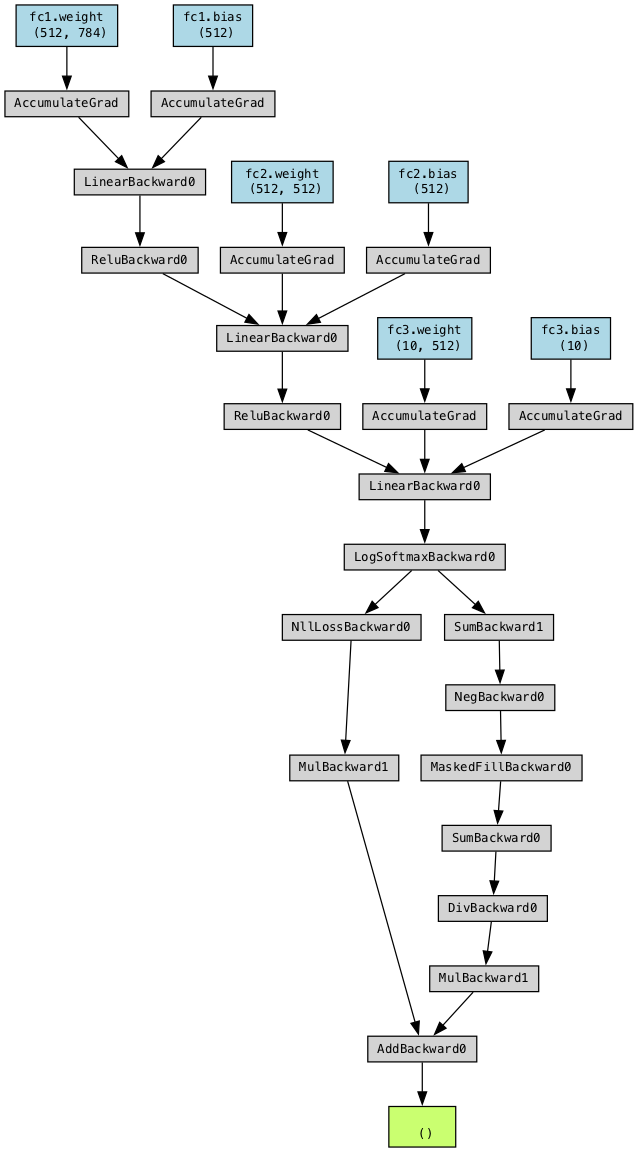

In [44]:
from torchviz import make_dot
from IPython.display import Image

toy_X = X_train_tensor[0].to(device)
toy_y = y_train_tensor[0].to(device)
toy_out = model(toy_X)
loss = cross_entropy(toy_out, toy_y)

graph = make_dot(loss, params=dict(model.named_parameters()))
graph.render("computational_graph", format="png", view=True)
Image("computational_graph.png")


### In PyTorch Lightning
- A high-level framework built on PyTorch that simplifies deep learning model training
- Same code, but extend `pl.LightingModule` instead of `nn.Module`
- Has a number of predefined functions. For instance:

``` python
class NeuralNetwork(pl.LightningModule):
    def __init__(self):
        pass # Initialize model
    
    def forward(self, x): 
        pass # Forward pass, return output tensor
    
    def configure_optimizers(self):
        pass # Configure optimizer (e.g. Adam)
    
    def training_step(self, batch, batch_idx):
        pass # Return loss tensor
    
    def validation_step(self, batch, batch_idx):
        pass # Return loss tensor
        
    def test_step(self, batch, batch_idx):
        pass # Return loss tensor
```


Our entire example now becomes:

``` python
import pytorch_lightning as pl

class NeuralNetwork(pl.LightningModule):
    def __init__(self):
        super(LitNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        return self.criterion(outputs, y_batch)

    def configure_optimizers(self):
        return optim.RMSprop(self.parameters(), lr=0.001, momentum=0.0)

model = NeuralNetwork()    
```

In [45]:
import pytorch_lightning as pl

class NeuralNetwork(pl.LightningModule):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)                 # Logits (raw outputs)
        loss = self.criterion(outputs, y_batch) # Loss
        preds = torch.argmax(outputs, dim=1)    # Predictions
        acc = self.accuracy(preds, y_batch)
        self.log("train_loss", loss, sync_dist=True)
        self.log("train_acc", acc, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, y_batch)
        self.log("val_loss", loss, sync_dist=True, on_epoch=True)
        self.log("val_acc", acc, sync_dist=True, on_epoch=True)
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics["train_loss"].item()
        avg_acc = self.trainer.callback_metrics["train_acc"].item()
        print(f"Epoch {self.trainer.current_epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")

    def configure_optimizers(self):
        return optim.RMSprop(self.parameters(), lr=0.001, momentum=0.0)

model = NeuralNetwork()   

We can also get a nice model summary
- Lots of parameters (weights and biases) to learn!
    - hidden layer 1 : (28 * 28 + 1) * 512 = 401920
    - hidden layer 2 : (512 + 1) * 512 = 262656
    - output layer: (512 + 1) * 10 = 5130
    
``` python
ModelSummary(pl_model, max_depth=2)
```

In [46]:
from pytorch_lightning.utilities.model_summary import ModelSummary
ModelSummary(model, max_depth=2)

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | fc1       | Linear             | 401 K  | train
1 | fc2       | Linear             | 262 K  | train
2 | fc3       | Linear             | 5.1 K  | train
3 | criterion | CrossEntropyLoss   | 0      | train
4 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
669 K     Trainable params
0         Non-trainable params
669 K     Total params
2.679     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode

### Training
To log results while training, we can extend the training methods:

```python
def training_step(self, batch, batch_idx):
    X_batch, y_batch = batch
    outputs = self(X_batch)                 # Logits (raw outputs)
    loss = self.criterion(outputs, y_batch) # Loss
    preds = torch.argmax(outputs, dim=1)    # Predictions
    acc = self.accuracy(preds, y_batch)     # Metric
    self.log("train_loss", loss)            # self.log is the default
    self.log("train_acc", acc)              # TensorBoard logger
    return loss

def on_train_epoch_end(self): # Runs at the end of every epoch (e.g. to print something)
    avg_loss = self.trainer.callback_metrics["train_loss"].item()
    avg_acc = self.trainer.callback_metrics["train_acc"].item()
    print(f"Epoch {self.trainer.current_epoch}: Loss = {avg_loss:.4f}, Train accuracy = {avg_acc:.4f}")
```

We also need to implement the validation steps if we want validation scores
* Identical to `training_step` except for the logging

```python
def validation_step(self, batch, batch_idx):
    X_batch, y_batch = batch
    outputs = self(X_batch)
    loss = self.criterion(outputs, y_batch)
    preds = torch.argmax(outputs, dim=1)
    acc = self.accuracy(preds, y_batch)
    self.log("val_loss", loss, on_epoch=True)
    self.log("val_acc", acc, on_epoch=True)
    return loss
```

### Lightning Trainer
For training, we can now create a trainer and fit it. This will also automatically move everything to GPU.
```
trainer = pl.Trainer(max_epochs=3, accelerator="gpu") # Or 'cpu'
trainer.fit(model, train_loader)
```

In [47]:
import logging # Cleaner output
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
        
trainer = pl.Trainer(max_epochs=3, 
                     accelerator="gpu" if torch.cuda.is_available() or torch.backends.mps.is_available() else "cpu")
trainer.fit(model, train_loader)

Training: |                                                                                                   …

Epoch 1: Loss = 0.7552, Accuracy = 0.8000
Epoch 2: Loss = 0.4325, Accuracy = 0.8500
Epoch 3: Loss = 0.4669, Accuracy = 0.8500


#### Choosing training hyperparameters
* Number of epochs: enough to allow convergence
    * Too much: model starts overfitting (or levels off and just wastes time)
* Batch size: small batches (e.g. 32, 64,... samples) often preferred
    * 'Noisy' training data makes overfitting less likely
        * Large batches generalize less well ('generalization gap')
    * Requires less memory (especially in GPUs)
    * Large batches do speed up training, may converge in fewer epochs
* [Batch size interacts with learning rate](https://openreview.net/pdf?id=B1Yy1BxCZ)
    * Instead of shrinking the learning rate you can increase batch size

In [48]:
# Same model, more silent

class NeuralNetwork(pl.LightningModule):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)                 # Logits (raw outputs)
        loss = self.criterion(outputs, y_batch) # Loss
        preds = torch.argmax(outputs, dim=1)    # Predictions
        acc = self.accuracy(preds, y_batch)
        self.log("train_loss", loss, sync_dist=True)
        self.log("train_acc", acc, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, y_batch)
        self.log("val_loss", loss, sync_dist=True, on_epoch=True)
        self.log("val_acc", acc, sync_dist=True, on_epoch=True)
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics["train_loss"].item()
        avg_acc = self.trainer.callback_metrics["train_acc"].item()

    def configure_optimizers(self):
        return optim.RMSprop(self.parameters(), lr=0.001, momentum=0.0)

model = NeuralNetwork() 

In [49]:
from pytorch_lightning.callbacks import Callback
from IPython.display import clear_output

# First try. Not very efficient yet.
class TrainingPlotCallback(Callback):
    def __init__(self, update_interval=100, smoothing=100):
        """
        Callback to plot training and validation progress.

        Args:
            update_interval (int): Number of batches between updates.
            smoothing (int): Window size for moving average.
        """
        super().__init__()
        self.update_interval = update_interval
        self.smoothing = smoothing
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.val_x_positions = []  # Store x positions for validation scores
        self.max_acc = 0
        self.global_step = 0  # Tracks processed training batches
        self.epoch_count = 0  # Tracks processed epochs
        self.steps_per_epoch = 0  # Updated dynamically to track num_batches per epoch

    def moving_average(self, values, window):
        """Computes a simple moving average for smoothing."""
        if len(values) < window:
            return np.convolve(values, np.ones(len(values)) / len(values), mode="valid")
        return np.convolve(values, np.ones(window) / window, mode="valid")

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Updates training loss and accuracy every `update_interval` batches."""
        self.global_step += 1
        logs = trainer.callback_metrics

        # Store training loss and accuracy
        if "train_loss" in logs:
            self.losses.append(logs["train_loss"].item())
        if "train_acc" in logs:
            self.acc.append(logs["train_acc"].item())

        # Update plot every `update_interval` training batches
        if self.global_step % self.update_interval == 0:
            self.plot_progress()

    def on_validation_epoch_end(self, trainer, pl_module):
        """Updates validation loss and accuracy at the end of each epoch, scaling x-axis correctly."""
        logs = trainer.callback_metrics
        self.epoch_count += 1
        if self.steps_per_epoch == 0:
            self.steps_per_epoch = self.global_step

        self.val_x_positions.append(self.global_step)

        # Retrieve validation metrics from trainer
        if "val_loss" in logs:
            self.val_losses.append(logs["val_loss"].item())
        if "val_acc" in logs:
            val_acc = logs["val_acc"].item()
            self.val_acc.append(val_acc)
            self.max_acc = max(self.max_acc, val_acc)
            
    def on_train_end(self, trainer, pl_module):
        """Ensures the final validation curve is plotted after the last epoch."""
        self.plot_progress()
            
    def plot_progress(self):
        """Plots training and validation metrics with moving averages."""
        clear_output(wait=True)
        steps = np.arange(1, len(self.losses) + 1)

        plt.figure(figsize=(8, 4))
        plt.ylim(0, 1)  # Constrain y-axis between 0 and 1

        # Training curves
        plt.plot(steps / self.steps_per_epoch, self.losses, lw=0.2, alpha=0.3, c="b", linestyle="-")
        plt.plot(steps / self.steps_per_epoch, self.acc, lw=0.2, alpha=0.3, c="r", linestyle="-")

        # Moving average (thicker line)
        if len(self.losses) >= self.smoothing:
            plt.plot(steps[self.smoothing - 1:] / self.steps_per_epoch, self.moving_average(self.losses, self.smoothing),
                     lw=1, c="b", linestyle="-", label="Train Loss")
        if len(self.acc) >= self.smoothing:
            plt.plot(steps[self.smoothing - 1:] / self.steps_per_epoch, self.moving_average(self.acc, self.smoothing),
                     lw=1, c="r", linestyle="-", label="Train Acc")

        # Validation curves (scaled to correct x-positions)
        if self.val_losses:
            plt.plot(np.array(self.val_x_positions) / self.steps_per_epoch, self.val_losses, c="b", linestyle=":", label="Val Loss", lw=2)
        if self.val_acc:
            plt.plot(np.array(self.val_x_positions) / self.steps_per_epoch, self.val_acc, c="r", linestyle=":", label="Val Acc", lw=2)

        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss/Accuracy", fontsize=12)
        plt.title(f"Training Progress (Step {self.global_step}, Epoch {self.epoch_count}, Max Val Acc {self.max_acc:.4f})", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(fontsize=10)
        plt.show()

In [ ]:
import gc
torch.mps.empty_cache()
gc.collect()

accelerator = "cpu"
if torch.backends.mps.is_available():
    accelerator = "mps"
if torch.cuda.is_available():
    accelerator = "gpu"

trainer = pl.Trainer(
    max_epochs=15,
    enable_progress_bar=False,
    accelerator=accelerator,
    callbacks=[TrainingPlotCallback()] # Attach the callback
)
trainer.fit(model, train_loader, test_loader)

## Model selection
* How many epochs do we need for training?
* Train the neural net and track the loss after every iteration on a validation set
    * You can add a callback to the fit version to get info on every epoch
* Best model after a few epochs, then starts overfitting

### Early stopping
* Stop training when the validation loss (or validation accuracy) no longer improves
* Loss can be bumpy: use a moving average or wait for $k$ steps without improvement

``` python
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", # minimize validation loss
    patience=3)                     # Number of epochs with no improvement before stopping
          
# Update the Trainer to include early stopping as a callback
trainer = pl.Trainer(
    max_epochs=10, accelerator=accelerator,
    callbacks=[TrainingPlotCallback(), early_stopping]  # Attach the callbacks
)
```

In [ ]:
trainer = pl.Trainer(
    max_epochs=15,
    enable_progress_bar=False,
    accelerator=accelerator,
    callbacks=[TrainingPlotCallback(), early_stopping]  # Attach the callbacks
)
trainer.fit(model, train_loader, test_loader)

### Regularization and memorization capacity
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - Too high capacity causes overfitting, too low causes underfitting
    - In the extreme, the training set can be 'memorized' in the weights
* Smaller models are forced it to learn a compressed representation that generalizes better
    - Find the sweet spot: e.g. start with few parameters, increase until overfitting stars.
* Example: 256 nodes in first layer, 32 nodes in second layer, similar performance
    - Avoid _bottlenecks_: layers so small that information is lost

```pytorch
self.fc1 = nn.Linear(28 * 28, 256)
self.fc2 = nn.Linear(256, 32)
self.fc3 = nn.Linear(32, 10)
```

#### Weight regularization (weight decay)
* We can also add weight regularization to our loss function (or invent your own)
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights

``` python
def training_step(self, batch, batch_idx):
    X_batch, y_batch = batch
    outputs = self(X_batch)                 
    loss = self.criterion(outputs, y_batch)
    l1_lambda = 1e-5 # L1 Regularization
    l1_loss = sum(p.abs().sum() for p in self.parameters())
    l2_lambda = 1e-4 # L2 Regularization
    l2_loss = sum((p ** 2).sum() for p in self.parameters())
    return loss + l2_lambda * l2_loss  # Using L2 only
```

Alternative: set `weight_decay` in the optimizer (only for L2 loss)

``` python
def configure_optimizers(self):
    return optim.RMSprop(self.parameters(), lr=0.001, momentum=0.0, weight_decay=1e-4)
```

### Dropout
* Every iteration, randomly set a number of activations $a_i$ to 0
* _Dropout rate_ : fraction of the outputs that are zeroed-out (e.g. 0.1 - 0.5)
    * Use higher dropout rates for deeper networks
* Use higher dropout in early layers, lower dropout later
    * Early layers are usually larger, deeper layers need stability
* Idea: break up accidental non-significant learned patterns 
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training

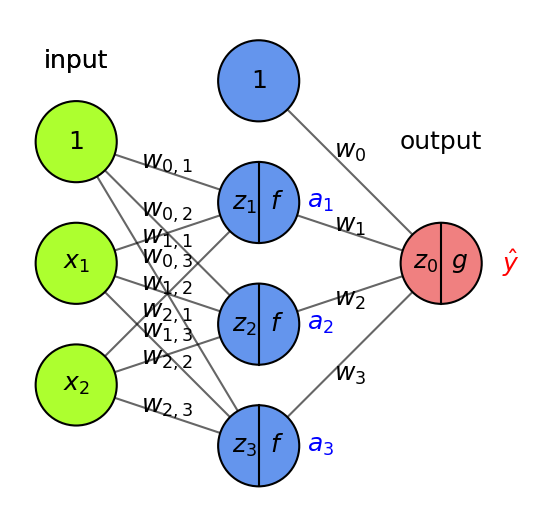

In [52]:
fig = plt.figure(figsize=(4*fig_scale, 4*fig_scale))
ax = fig.gca()
draw_neural_net(ax, [2, 3, 1], draw_bias=True, labels=True, 
                show_activations=True, activation=True)

#### Dropout layers
* Dropout is usually implemented as a special layer

``` python
def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 512)
    self.dropout1 = nn.Dropout(p=0.2)  # 20% dropout
    self.fc2 = nn.Linear(512, 512)
    self.dropout2 = nn.Dropout(p=0.1)  # 10% dropout
    self.fc3 = nn.Linear(512, 10)

def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)  # Apply dropout
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)  # Apply dropout
    return self.fc3(x)
```

#### Batch Normalization
* We've seen that scaling the input is important, but what if layer activations become very large? 
    * Same problems, starting deeper in the network
* Batch normalization: normalize the activations of the previous layer within each batch
    * Within a batch, set the mean activation close to 0 and the standard deviation close to 1
        * Across badges, use exponential moving average of batch-wise mean and variance
    * Allows deeper networks less prone to vanishing or exploding gradients

#### BatchNorm layers
* Batch normalization is also usually implemented as a special layer

``` python
def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 512)
    self.bn1 = nn.BatchNorm1d(512)  # Batch normalization after first layer
    self.fc2 = nn.Linear(512, 265)
    self.bn2 = nn.BatchNorm1d(265)  # Batch normalization after second layer
    self.fc3 = nn.Linear(265, 10)

def forward(self, x):
    x = x.view(x.size(0), -1)  # Flatten the image
    x = F.relu(self.bn1(self.fc1(x)))  # Apply batch norm after linear layer
    x = F.relu(self.bn2(self.fc2(x)))  # Apply batch norm after second linear layer
    return self.fc3(x)
```


### New model
```python
class NeuralNetwork(pl.LightningModule):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 265)
        self.bn1 = nn.BatchNorm1d(265)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(265, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(32, 10)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x
```


### New model (Sequential API)
``` python
model = nn.Sequential(
        nn.Linear(28 * 28, 265),
        nn.BatchNorm1d(265),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(265, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(32, 10))
```

## Summary

* Neural architectures
* Training neural nets
    * Forward pass: Tensor operations
    * Backward pass: Backpropagation
* Neural network design:
    * Activation functions
    * Weight initialization
    * Optimizers
* Neural networks in practice
* Model selection
    * Early stopping
    * Memorization capacity and information bottleneck
    * L1/L2 regularization
    * Dropout
    * Batch normalization